# A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification
## Introduction
- Machine learning models are used in high-risk settings, which demand uncertainty quantification to avoid failures
- **Conformal prediction**: User friendly paradigm for creating statistically rigorous uncertainty sets/intervals for model predictions
- Model agnostic
(content:references:labels)
## Conformal prediction
- First, fit a classifier $\hat{f}$ on $\textit{training data}$. 
- Then, create prediction sets using $\textit{calibration data}$
- Goal Construct a $\textit{prediction set}$ of possible labels $C(X_{test}) \subset \{1,2,3...,K\}$ such that $$1 - \alpha \leq \mathbb{P}(Y_{test} \in C(X_{test})) \leq 1 - \alpha + \frac{1}{n+1} $$ where $\alpha \in [0,1]$ is a user-chosen error rate
- The probability that the prediction set contains the true label is almost exactly $1-\alpha$. (**Marginal coverage**)
- Calibration step
  - Conformal score: $s_i = 1 - \hat{f}(X_i)_{Y_i}$. One minus the output for the true class
  - Define $\hat{q}$ to be the $\frac{\lceil (n+1)(1-\alpha) \rceil}{n}$ (empirical quantile but with small correction)
  - For a new test data point, prediction set will be $$C(X_{test}) = \{y: \hat{f}(X_{test})_{y} \geq 1 - \hat{q} \}$$ Includes all classes with a high enough softmax output
- Remarks
  - The set becomes larger when the model is uncertain/input is hard
- General outline
  - Identify a heuristic notion of uncertainty using the pretrained model
  - Define the score function $s(x,y) \in \mathbb{R}$ (Larger scores encode worse agreement between $x$ and $y$)
  - Compute $\hat{q}$ as $\frac{\lceil (n+1)(1-\alpha) \rceil}{n}$ using calibration set
  - Use this quantile to $$C(X_{test}) = \{y:s(X_{test},y) \leq \hat{q} \}$$
  - The usefullness of the predictions sets is primarily determined by the score function.
## Examples of Conformal procedures
### Classification with Adaptive Prediction Sets
- Score function $s(x,y) = \sum_{j=1}^k \hat{f}(x)_{\pi_j(x)}$, where $y = \pi_k(x)$
- $\pi_{x}$ is the permutation function that sorts $\hat{f}$ from most likely to most unlikely
- In other words, include all classes in the set until it reaches the true label
- Find quantile $\hat{q}$
- Form the prediction set using $$C(x) = \{\pi_1(x),\pi_2(x),...,\pi_k(x)\},\textit{where k} = sup \left\{ k': \sum_{j=1}^{k'} \hat{f}(x)_{\pi_j(x)} <  \hat{q} \right\} + 1$$

## Conformalized Quantile Regression

# Code

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
! pip install -U --no-cache-dir gdown --pre

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

## Normal conformal prediction

In [30]:
n = 1000
alpha = 0.05

In [31]:
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [35]:
def q_level(alpha:float,n:int)->float:
    """alpha:  confidence level 
       n: Calibration data
       returns: ql corrected for finite data
    """
        
    ql = np.ceil((n+1)*(1-alpha))/n
    return ql

cal_scores = 1 - cal_smx[np.arange(n),cal_labels] # For each line, true class
print(cal_scores.shape)
ql = q_level(alpha,n)
qhat = np.quantile(cal_scores,ql,interpolation='higher')
print(qhat)
print(f"Include all classes such that the prediction is larger than {1-qhat}")
prediction_sets = val_smx >= (1-qhat)

(1000,)
0.9941999539732933
Include all classes such that the prediction is larger than 0.0058000460267066956


In [33]:
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels] ## Check value of true label in prediction set. If false, is not included
empirical_coverage.mean()

0.9539183673469388

In [48]:
total_classes =prediction_sets.shape[1]
prediction_sets_length = prediction_sets.sum(axis=1)
print(f"Total number of classes {total_classes}")
print(f"Average prediction set length {prediction_sets_length.mean().round(2)}")
print(f"Number of sets with length 1: {(prediction_sets_length==1).mean()}")

Total number of classes 1000
Average prediction set length 3.95
Number of sets with length 1: 0.3849795918367347


C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


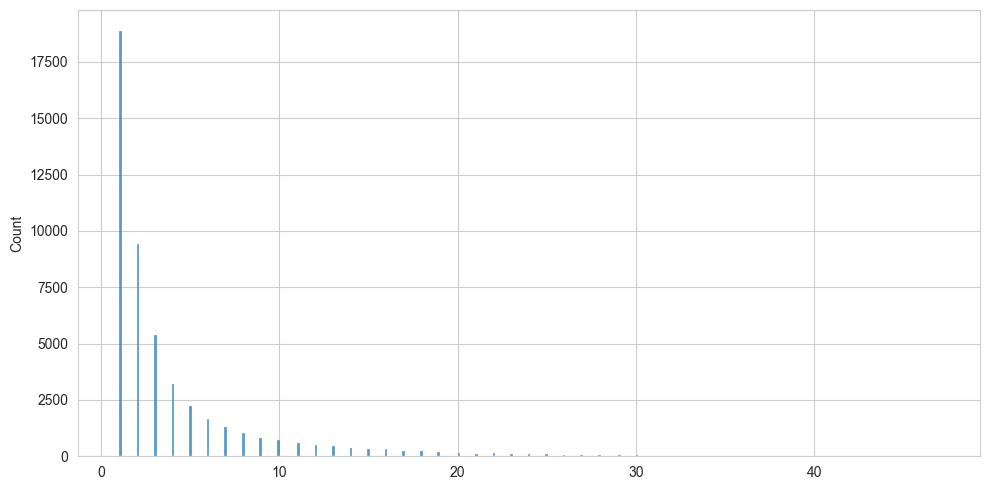

In [47]:
import seaborn as sns
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(10,5))
_ = sns.histplot(prediction_sets_length,ax=ax)
plt.tight_layout()

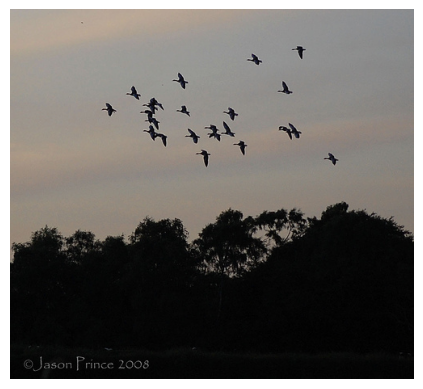

The prediction set is: ['goose', 'white stork', 'flamingo', 'crane (bird)', 'pelican']


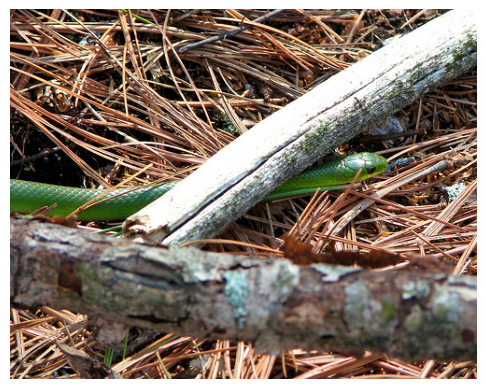

The prediction set is: ['European green lizard', 'worm snake', 'smooth green snake', 'garter snake', 'vine snake', 'green mamba', 'grasshopper', 'cricket', 'stick insect', 'mantis', 'zucchini', 'cucumber', 'stinkhorn mushroom']


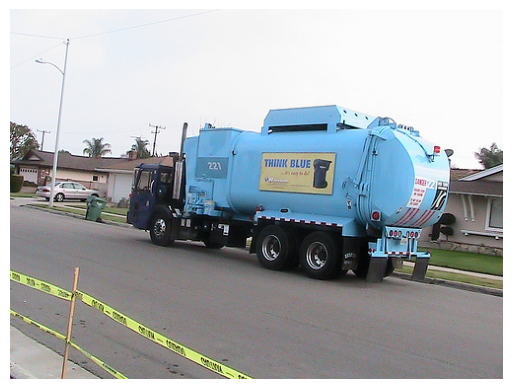

The prediction set is: ['garbage truck']


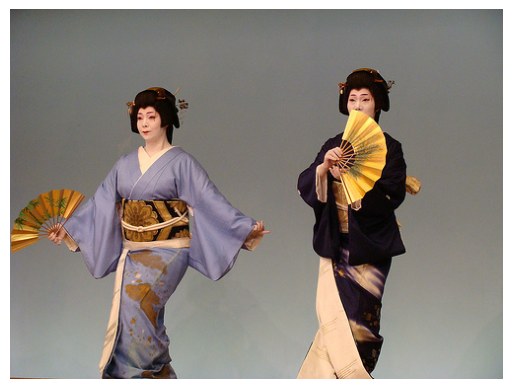

The prediction set is: ['kimono']


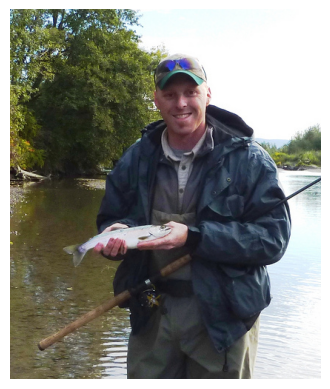

The prediction set is: ['snoek', 'coho salmon']


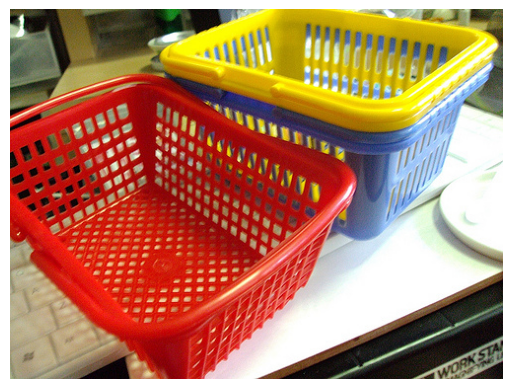

The prediction set is: ['shopping basket']


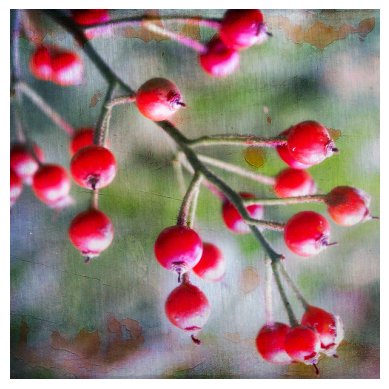

The prediction set is: ['rose hip']


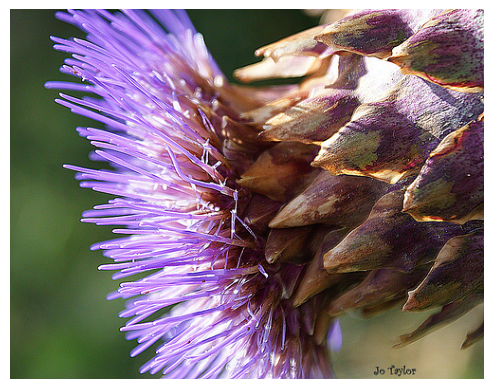

The prediction set is: ['artichoke', 'cardoon']


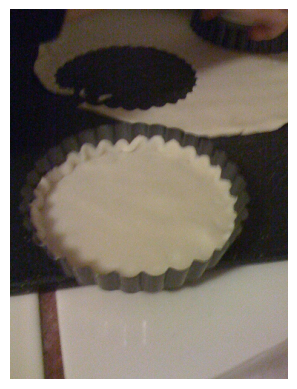

The prediction set is: ['bolo tie', 'bottle cap', 'buckle']


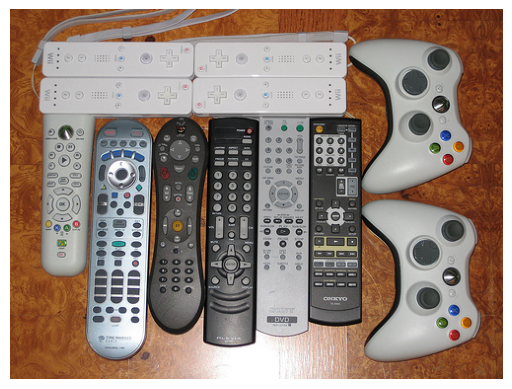

The prediction set is: ['remote control']


In [49]:
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

## Adaptive prediction sets

In [74]:
n = 1000  # number of calibration points
alpha = 0.1  # 1-alpha is the desired coverage
idx = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx, :], smx[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]

In [75]:
cal_pi = cal_smx.argsort(1)[:, ::-1] ## Sort by column, all lines, reverse to be decreasing

In [76]:
cal_pi.argsort(axis=1)

array([[  0,   8, 199, ...,  14,  53, 969],
       [ 21,   0, 434, ..., 366, 251, 387],
       [ 51,  44,   2, ..., 395, 521, 356],
       ...,
       [ 14, 676, 924, ...,   0, 187, 913],
       [347, 284, 880, ..., 208,   1,  63],
       [958, 452, 872, ..., 900, 316,   0]], dtype=int64)

In [77]:
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1) ## Take row wise
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[ ## Goes back to true label orders
    range(n), cal_labels] # For every row, take up until the true label

In [78]:
qhat = np.quantile(
    cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
)

In [79]:
val_pi = val_smx.argsort(1)[:, ::-1] ## Most likely class to least likely 
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1) # Cumsum from the permutation from most likely to least likely
prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1) # Create boolean vector and reorders to the original class order

In [80]:
empirical_coverage = prediction_sets[
    np.arange(prediction_sets.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.904


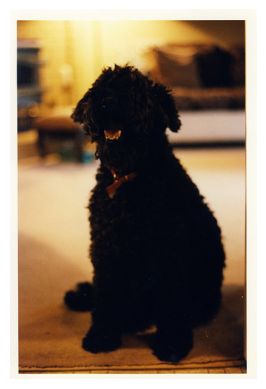

The prediction set is: ['Kerry Blue Terrier', 'Lakeland Terrier', 'Airedale Terrier', 'Giant Schnauzer', 'Scottish Terrier', 'Curly-coated Retriever', 'Irish Water Spaniel', 'Briard', 'Bouvier des Flandres', 'Affenpinscher', 'Toy Poodle', 'Miniature Poodle', 'Standard Poodle']


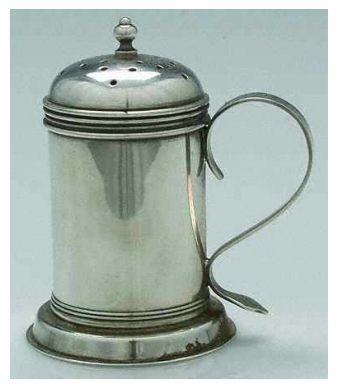

The prediction set is: ['goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'chickadee', 'American dipper', 'kite', 'smooth newt', 'spotted salamander', 'axolotl', 'mud turtle', 'terrapin', 'green iguana', 'desert grassland whiptail lizard', 'frilled-necked lizard', 'alligator lizard', 'European green lizard', 'worm snake', 'ring-necked snake', 'vine snake', 'night snake', 'Indian cobra', 'green mamba', 'sea snake', 'Saharan horned viper', 'barn spider', 'tick', 'centipede', 'ruffed grouse', 'prairie grouse', 'quail', 'partridge', 'grey parrot', 'sulphur-crested cockatoo', 'coucal', 'hummingbird', 'red-breasted merganser', 'goose', 'platypus', 'jellyfish', 'flatworm', 'nematode', 'conch', 'snail', 'chambered nautilus', 'Dungeness crab', 'red king crab', 'American lobster', 'crayfish', 'great egret', 'American coot', 'bustard', 'ruddy turnstone', 'common

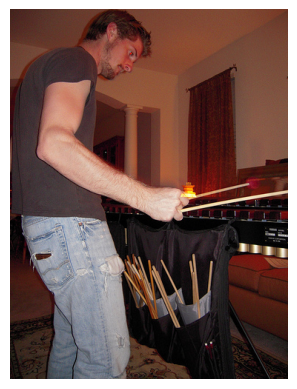

The prediction set is: ['great white shark', 'cock', 'brambling', 'fire salamander', 'spotted salamander', 'terrapin', 'alligator lizard', 'Gila monster', 'triceratops', 'worm snake', 'ring-necked snake', 'kingsnake', 'garter snake', 'night snake', 'boa constrictor', 'African rock python', 'eastern diamondback rattlesnake', 'trilobite', 'scorpion', 'tarantula', 'tick', 'centipede', 'grey parrot', 'echidna', 'conch', 'slug', 'Dungeness crab', 'rock crab', 'fiddler crab', 'red king crab', 'American lobster', 'spiny lobster', 'crayfish', 'hermit crab', 'pelican', 'king penguin', 'Chihuahua', 'Pekingese', 'Shih Tzu', 'Papillon', 'toy terrier', 'borzoi', 'Italian Greyhound', 'Whippet', 'Ibizan Hound', 'Norwegian Elkhound', 'Bedlington Terrier', 'Kerry Blue Terrier', 'Yorkshire Terrier', 'Cairn Terrier', 'Scottish Terrier', 'Lhasa Apso', 'Labrador Retriever', 'Chesapeake Bay Retriever', 'Schipperke', 'Malinois', 'Komondor', 'Shetland Sheepdog', 'German Shepherd Dog', 'Dobermann', 'Miniature 

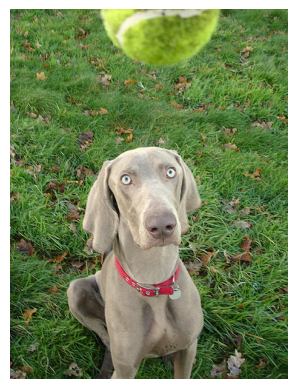

The prediction set is: ['Italian Greyhound', 'Weimaraner', 'Great Dane']


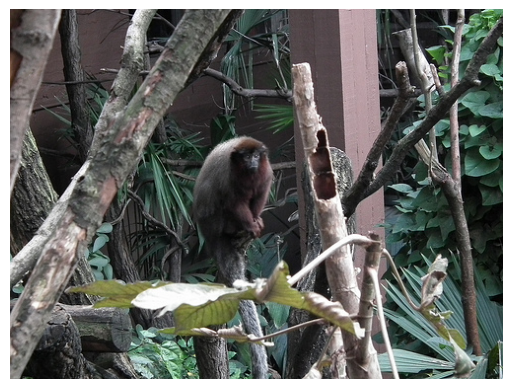

The prediction set is: ['vulture', 'koala', 'sloth bear', 'porcupine', 'beaver', 'three-toed sloth', 'orangutan', 'gorilla', 'chimpanzee', 'gibbon', 'siamang', 'guenon', 'patas monkey', 'baboon', 'macaque', 'langur', 'black-and-white colobus', 'proboscis monkey', 'marmoset', 'white-headed capuchin', 'howler monkey', 'titi', "Geoffroy's spider monkey", 'common squirrel monkey', 'ring-tailed lemur', 'indri', 'red panda', 'giant panda']


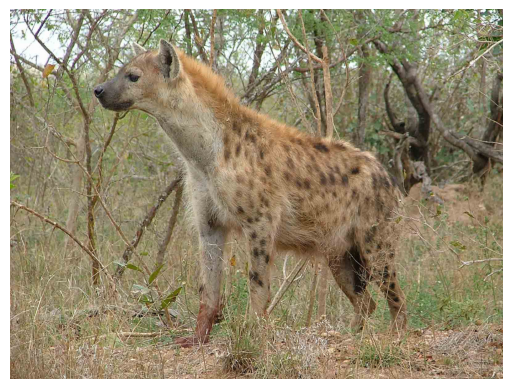

The prediction set is: ['ostrich', 'brambling', 'American robin', 'kite', 'vulture', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'tailed frog', 'banded gecko', 'desert grassland whiptail lizard', 'agama', 'Gila monster', 'Komodo dragon', 'Nile crocodile', 'night snake', 'boa constrictor', 'African rock python', 'Indian cobra', 'Saharan horned viper', 'sidewinder', 'scorpion', 'barn spider', 'European garden spider', 'tarantula', 'wolf spider', 'tick', 'centipede', 'ruffed grouse', 'prairie grouse', 'peacock', 'quail', 'partridge', 'wallaby', 'wombat', 'fiddler crab', 'crayfish', 'crane (bird)', 'bustard', 'dunlin', 'Chihuahua', 'toy terrier', 'Rhodesian Ridgeback', 'Afghan Hound', 'Treeing Walker Coonhound', 'English foxhound', 'Redbone Coonhound', 'borzoi', 'Irish Wolfhound', 'Italian Greyhound', 'Whippet', 'Ibizan Hound', 'Saluki', 'Scottish Deerhound', 'Staffordshire Bull Terrier', 'Border Terrier', 'Irish Terrier', 'Norwich Terrier', 'Cairn Terrier', 'Australian

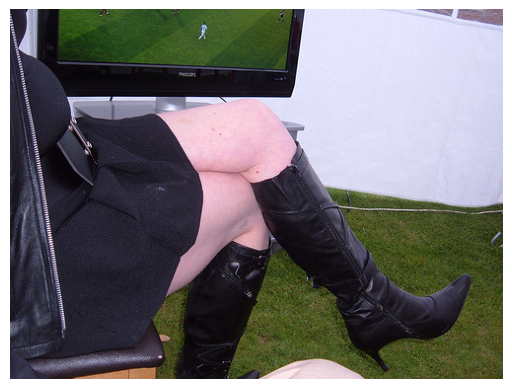

The prediction set is: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'American robin', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock python', 'Indian cobra', 'green mamba', 'sea snake', 'Saharan horned viper', 'eastern diamondback rattlesnake', 'sidewinder', 'trilobite', 'harv

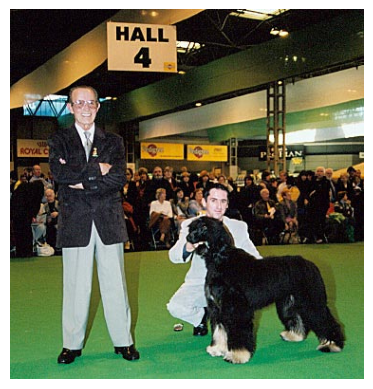

The prediction set is: ['great grey owl', 'night snake', 'Japanese Chin', 'King Charles Spaniel', 'Papillon', 'Rhodesian Ridgeback', 'Afghan Hound', 'Basset Hound', 'Bloodhound', 'Bluetick Coonhound', 'Black and Tan Coonhound', 'English foxhound', 'borzoi', 'Irish Wolfhound', 'Whippet', 'Ibizan Hound', 'Otterhound', 'Saluki', 'Scottish Deerhound', 'Weimaraner', 'Staffordshire Bull Terrier', 'American Staffordshire Terrier', 'Bedlington Terrier', 'Kerry Blue Terrier', 'Irish Terrier', 'Wire Fox Terrier', 'Lakeland Terrier', 'Sealyham Terrier', 'Airedale Terrier', 'Dandie Dinmont Terrier', 'Boston Terrier', 'Miniature Schnauzer', 'Giant Schnauzer', 'Standard Schnauzer', 'Scottish Terrier', 'Tibetan Terrier', 'Soft-coated Wheaten Terrier', 'West Highland White Terrier', 'Lhasa Apso', 'Flat-Coated Retriever', 'Curly-coated Retriever', 'Golden Retriever', 'Labrador Retriever', 'German Shorthaired Pointer', 'Vizsla', 'English Setter', 'Irish Setter', 'Gordon Setter', 'Brittany', 'Clumber Spa

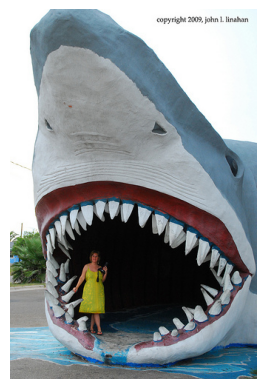

The prediction set is: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'goldfinch', 'house finch', 'junco', 'American robin', 'bulbul', 'jay', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'alligator lizard', 'European green lizard', 'Nile crocodile', 'American alligator', 'triceratops', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock python', 'Indian cobra', 'green mamba', 'trilobite', 'scorpion', 'yellow garden spider', 'barn spider', 'European garden spider', 'tarantula', 'wolf spider', 'tick', 'centipede', 'black grouse', 'ptarmigan', 'ruffed grouse', 'prairie grouse', 'peacock',

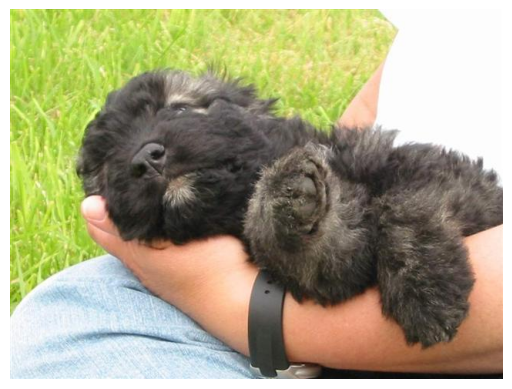

The prediction set is: ['Maltese', 'Pekingese', 'Shih Tzu', 'Afghan Hound', 'Irish Wolfhound', 'Otterhound', 'Scottish Deerhound', 'Bedlington Terrier', 'Kerry Blue Terrier', 'Irish Terrier', 'Norfolk Terrier', 'Lakeland Terrier', 'Sealyham Terrier', 'Cairn Terrier', 'Dandie Dinmont Terrier', 'Miniature Schnauzer', 'Giant Schnauzer', 'Standard Schnauzer', 'Scottish Terrier', 'Tibetan Terrier', 'Soft-coated Wheaten Terrier', 'Lhasa Apso', 'Cocker Spaniels', 'Irish Water Spaniel', 'Briard', 'Komondor', 'Old English Sheepdog', 'Bouvier des Flandres', 'Tibetan Mastiff', 'Affenpinscher', 'Newfoundland', 'Chow Chow', 'Keeshond', 'Toy Poodle', 'Miniature Poodle', 'Standard Poodle', 'Persian cat', 'Angora rabbit', 'skunk']


In [81]:
with open("../data/imagenet/human_readable_labels.json") as f:
    label_strings = np.array(json.load(f))

example_paths = os.listdir("../data/imagenet/examples")
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread("../data/imagenet/examples/" + rand_path)
    img_index = int(rand_path.split(".")[0])
    img_pi = smx[img_index].argsort()[::-1]
    img_srt = np.take_along_axis(smx[img_index], img_pi, axis=0).cumsum()
    prediction_set = np.take_along_axis(img_srt <= qhat, img_pi.argsort(), axis=0)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")